# Results S-ARIMA modelling 

In [6]:
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import numpy as np
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt

In [11]:
register_matplotlib_converters()
sns.set_style("darkgrid")
plt.rc("figure", figsize=(8, 8))
plt.rc("font", size=13)

## Import training and test data of the UK smart meter data

In [19]:
import os
# print path
print(os.getcwd())

/Users/saschimi/Documents/github/ml4gd-project-group-3/arima


In [22]:
import pickle

filepath = "../uk-smart-meter-aggregated/"
filename = "df_agg_drive.pkl"
# load pickle file
with open(filepath+filename, "rb") as f:
    df = pickle.load(f)
df.head()

,2,3,4,6,7,8,9,10,11,12,...,5535,5536,5537,5538,5541,5549,5550,5551,5557,5564
DateTime,,,,,,,,,,,,,,,,,,,,,
2012-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
df

DatetimeIndex(['2012-01-01 00:00:00', '2012-01-01 01:00:00',
               '2012-01-01 02:00:00', '2012-01-01 03:00:00',
               '2012-01-01 04:00:00', '2012-01-01 05:00:00',
               '2012-01-01 06:00:00', '2012-01-01 07:00:00',
               '2012-01-01 08:00:00', '2012-01-01 09:00:00',
               ...
               '2013-12-31 14:00:00', '2013-12-31 15:00:00',
               '2013-12-31 16:00:00', '2013-12-31 17:00:00',
               '2013-12-31 18:00:00', '2013-12-31 19:00:00',
               '2013-12-31 20:00:00', '2013-12-31 21:00:00',
               '2013-12-31 22:00:00', '2013-12-31 23:00:00'],
              dtype='datetime64[ns]', name='DateTime', length=17544, freq=None)

array([<Axes: xlabel='DateTime'>, <Axes: xlabel='DateTime'>,
       <Axes: xlabel='DateTime'>, <Axes: xlabel='DateTime'>,
       <Axes: xlabel='DateTime'>], dtype=object)

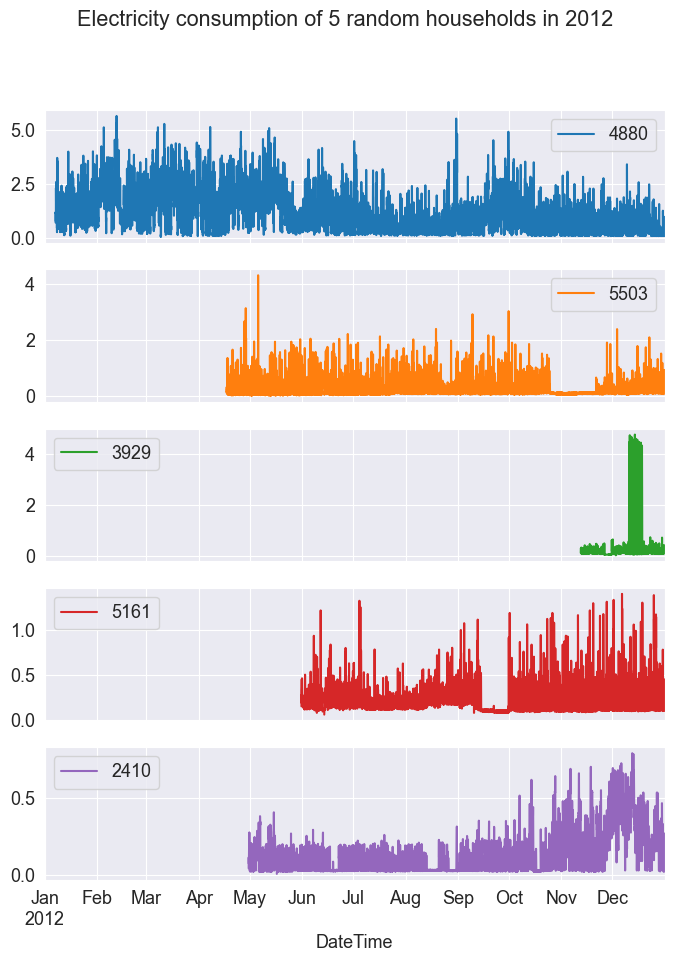

In [132]:
# Take five random households and create a time series plot of their electricity consumption
seed = 1985
np.random.seed(seed)
random_households = np.random.choice(df.columns, 5)
# Rows for DateTime = 2012-01-01 00:00:00 to 2012-12-31 23:00:00
df_range = df[(df.index >= "2012-01-01 00:00:00") & (df.index <= "2012-12-31 23:00:00")]
five_households = df_range[random_households]
five_households.plot(subplots=True, figsize=(8, 10), title="Electricity consumption of 5 random households in 2012")

In [133]:
print(five_households.describe())
print(five_households)

              4880         5503         3929         5161         2410
count  8630.000000  6161.000000  1190.000000  5124.000000  5849.000000
mean      1.131299     0.252373     0.543303     0.231334     0.127354
std       0.911612     0.306568     1.117999     0.162282     0.136685
min       0.081000     0.001000     0.042000     0.056000     0.007000
25%       0.386250     0.096000     0.104000     0.120000     0.030000
50%       0.870000     0.139000     0.183000     0.176000     0.069000
75%       1.652000     0.273000     0.288000     0.295000     0.164000
max       5.626000     4.301000     4.759000     1.407000     0.787000
                      4880   5503   3929   5161   2410
DateTime                                              
2012-01-01 00:00:00    NaN    NaN    NaN    NaN    NaN
2012-01-01 01:00:00    NaN    NaN    NaN    NaN    NaN
2012-01-01 02:00:00    NaN    NaN    NaN    NaN    NaN
2012-01-01 03:00:00    NaN    NaN    NaN    NaN    NaN
2012-01-01 04:00:00    NaN    N

In [134]:
# Split data into training and testing sets
train_set = 1200
test_set = five_households.shape[0] - train_set
print("Sizes of training and testing sets:", train_set, test_set)


Sizes of training and testing sets: 1200 7584


## Create ARIMA model for the first household

array([<Axes: xlabel='DateTime'>], dtype=object)

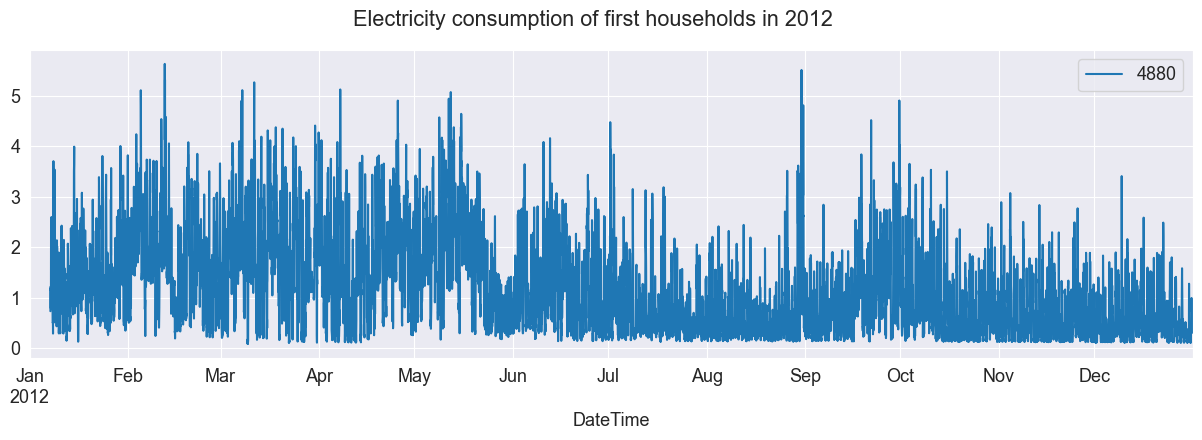

In [135]:
# Graph data
five_households.iloc[:, 0:1].plot(subplots=True, figsize=(15,4), title='Electricity consumption of first households in 2012')

## Analyse seasonality for the first household

In [136]:
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.seasonal import DecomposeResult

# Should be imported
def impute_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """Fill missing values in the dataframe with the last known value of the timeseries. If the previous value is missing, fill with the next known value.

        Args:
        df (pd.DataFrame): 1D timeseries given as a pandas dataframe with the values in the field specified by value_axis.
    """
    # Find last value that is not NaN or zero before a value that is NaN or zero
    df.replace(0, np.nan, inplace=True)
    df.ffill(inplace=True, axis=0)
    df.bfill(inplace=True, axis=0)
    return df


In [137]:
five_households.iloc[0:train_set, 0:1]


,4880
DateTime,
2012-01-01 00:00:00,NaN
2012-01-01 01:00:00,NaN
2012-01-01 02:00:00,NaN
2012-01-01 03:00:00,NaN
2012-01-01 04:00:00,NaN
...,...
2012-02-19 19:00:00,3.335
2012-02-19 20:00:00,4.075
2012-02-19 21:00:00,3.275


## Analyse seasonality and select the seasonality that is more prominent
The SARIMAX model can only handle single seasonality, this means, we need to select one period.

**Note**: We need to do data imputation because the MSTL seasonality detection cannot handle `NaN` values in the data.

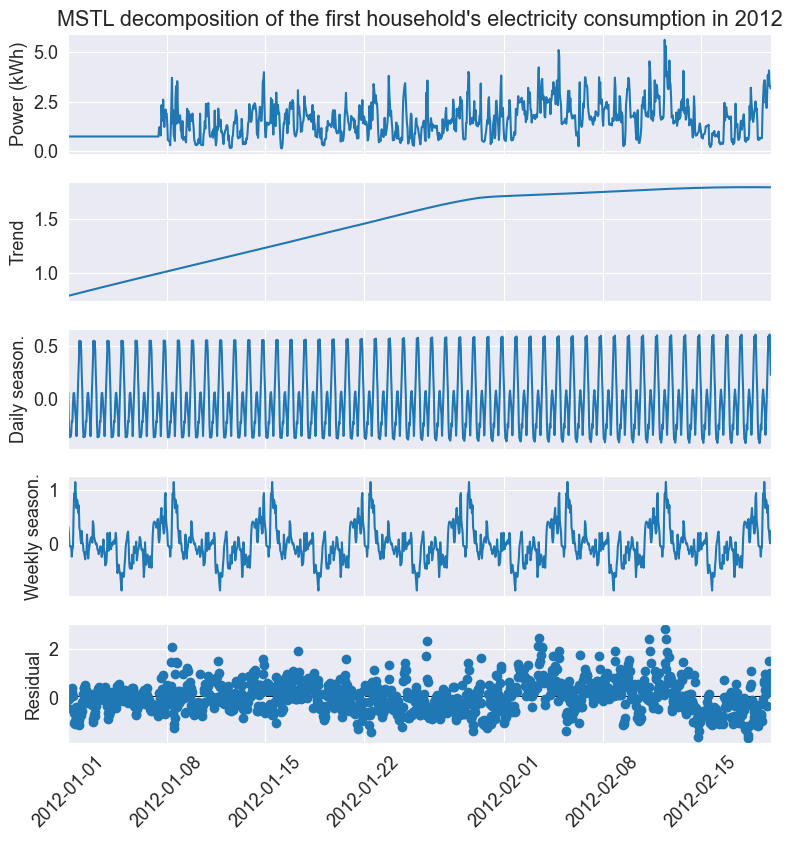

In [140]:
mstl = MSTL(
    impute_missing_values(five_households.iloc[0:train_set, 0:1]),
    periods=[24, 24 * 7],  # The periods and windows must be the same length and will correspond to one another.
    windows=[101, 101],  # Setting this large along with `seasonal_deg=0` will force the seasonality to be periodic.
    iterate=3,
    stl_kwargs={
                "trend":1001, # Setting this large will force the trend to be smoother.
                "seasonal_deg":0, # Means the seasonal smoother is fit with a moving average.
               }
)
res = mstl.fit()
fig = res.plot()
ax = fig.get_axes()
# Access subplots y labels
ax[0].set_title("MSTL decomposition of the first household's electricity consumption in 2012")
ax[0].set_ylabel("Power (kWh)")
ax[1].set_ylabel("Trend")
ax[2].set_ylabel("Daily season.")
ax[3].set_ylabel("Weekly season.")
ax[4].set_ylabel("Residual")
ax[4].tick_params(axis='x', labelrotation=45)
fig.savefig("../figures/mstl_decomposition.pdf")

As we can see, the daily seasonality `24 h` follows a periodic pattern better than the weekly one. Hence, we select the daily seasonality for the model selection scheme in the next section.

## Fit SARIMAX models with single seasonality of 24h for all five households

In [120]:
import warnings

warnings.simplefilter('ignore')
def arima_aic(data, aic_full):
    """Train 6 times 6 ARIMA models with different p and q values and store the AIC values in a dataframe.

    Args:
        data (_type_): Time series data to train the ARIMA models on.
        aic_full (_type_): DataFrame to store the AIC values of the ARIMA models.
    """
    # Based on prior analysis, we know that the seasonality is 24 hours
    seasonal_order = (1,1,0,24) # (Seasonal AR specification, Seasonal Integration order, Seasonal MA, Seasonal periodicity)
    # Iterate over all ARMA(p,q) models with p,q in [0,6]
    for p in range(6):
        for q in range(6):
            # Baseline model does not have any AR or MA terms
            if p == 0 and q == 0:
                continue

            # Estimate the model with no missing datapoints
            mod = sm.tsa.statespace.SARIMAX(impute_missing_values(data),
                                            order=(p,0,q),
                                            seasonal_order=seasonal_order,
                                            enforce_invertibility=False)
            try:
                res = mod.fit(disp=False)
                aic_full.iloc[p,q] = res.aic
            except:
                aic_full.iloc[p,q] = np.nan


In [123]:
# AIC values for all five households, looking into 6x6 different models
best_models = []
# Iterate over all five households
for i in range(5):
    aic_full = pd.DataFrame(np.zeros((6,6), dtype=float))
    arima_aic(five_households.iloc[3000:3000+train_set, i:i+1], aic_full)
    # Find the ARMA(p,q) model with the lowest AIC
    print("Household", i+1)
    print(aic_full)
    p_full, q_full = np.unravel_index(aic_full.values.argmin(), aic_full.shape)
    print("Best ARMA(p,q) model:", p_full, q_full)
    best_models.append((p_full, q_full))


Household 1
0       0.000000
1   -2621.841348
2   -2661.291938
3   -2664.062618
4   -2679.770406
5   -2687.388455
Name: 0, dtype: float64
Best ARMA(p,q) model: 2 4
Household 2
0    -3653.918667
1    -3653.427066
2    -3736.117686
3    48268.301567
4    41956.802893
5    31455.993007
Name: 1, dtype: float64
Best ARMA(p,q) model: 5 5
Household 3
0    125.480160
1    123.187811
2    121.002522
3    117.969301
4    115.189217
5    115.138981
Name: 2, dtype: float64
Best ARMA(p,q) model: 0 0
Household 4
0    10.0
1    12.0
2    14.0
3    16.0
4    18.0
5    20.0
Name: 3, dtype: float64
Best ARMA(p,q) model: 1 0
Household 5
0    12.0
1    14.0
2    16.0
3    18.0
4    20.0
5    22.0
Name: 4, dtype: float64
Best ARMA(p,q) model: 1 0


In [ ]:

# ARIMA model for household 1
st1 = STL(five_households[:train_set, 0], seasonal=1)
res = st1.fit()
fig = res.plot()


# Graph data
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(data.iloc[1:]['D.ln_wpi'], lags=40, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(data.iloc[1:]['D.ln_wpi'], lags=40, ax=axes[1])


## Compute the ARIMA model that can handle missing data for a subset of the nodes

For each node we compare several ARIMA models based on the AIC, a information criterion to select models.
We then analyse if the majority of nodes would lead to the same ARIMA model (same order).

In [ ]:

# ARIMA model for household 2

# ARIMA model for household 3

# ARIMA model for household 4

# ARIMA model for household 5
